In [231]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import display, HTML
#import geopandas as gpd
#from shapely.geometry import Point

In [232]:
# Function to load and process files based on the given conditions
def process_files(file_list, column_order, rename_dict, drop_column=None):
    dfs = []
    for file in file_list:
        df = pd.read_csv(file, delimiter=';', on_bad_lines='skip', dtype=str)
        if "Accident_Id" in df.columns:
            df.rename(columns={"Accident_Id": "Num_Acc"}, inplace=True)
        if drop_column and drop_column in df.columns:
            df.drop(columns=[drop_column], inplace=True)
        df = df.reindex(columns=column_order)
        dfs.append(df)
    combined_df = pd.concat(dfs, ignore_index=True)
    combined_df.rename(columns=rename_dict, inplace=True)
    return combined_df

In [233]:
# Define file paths
source_folder = "source/"
caracteristiques_files = [os.path.join(source_folder, f) for f in os.listdir(source_folder) if f.startswith("caracteristiques")]
lieux_files = [os.path.join(source_folder, f) for f in os.listdir(source_folder) if f.startswith("lieux")]
usagers_files = [os.path.join(source_folder, f) for f in os.listdir(source_folder) if f.startswith("usagers")]
vehicules_files = [os.path.join(source_folder, f) for f in os.listdir(source_folder) if f.startswith("vehicules")]

In [234]:
# Define column orders and rename dictionaries
caracteristiques_columns = ["Num_Acc", "jour", "mois", "an", "hrmn", "lum", "dep", "com", "agg", "int", "atm", "col", "adr", "lat", "long"]
caracteristiques_rename = {"Num_Acc": "AccID", "jour": "day", "mois": "month", "an": "year", "hrmn": "time", "lum": "lum", 
                           "dep": "dep_code", "com": "com_code", "agg": "location", "int": "int", "atm": "atm_condition", 
                           "col": "collision_type", "adr": "address", "lat": "lat", "long": "long"}

lieux_columns = ["Num_Acc", "catr", "voie", "v1", "v2", "circ", "nbv", "vosp", "prof", "pr", "pr1", "plan", "lartpc", 
                 "larrout", "surf", "infra", "situ", "vma"]
lieux_rename = {"Num_Acc": "AccID", "catr": "route_category", "voie": "route_number", "v1": "route_number_index1", 
                "v2": "alph_route_index", "circ": "traffic_regime", "nbv": "total_number_lanes", "vosp": "reserved_lane_code", 
                "prof": "longitudinal_profile", "pr": "upstream_terminal_number", "pr1": "distance_upstream_terminal", 
                "plan": "plan", "lartpc": "width_central_reservation", "larrout": "width_roadway", "surf": "surface_condition", 
                "infra": "infra", "situ": "accident_situation", "vma": "maximum_speed"}

usagers_columns = ["Num_Acc", "id_vehicule", "num_veh", "place", "catu", "grav", "sexe", "an_nais", "trajet", "secu1", 
                   "secu2", "secu3", "locp", "actp", "etatp"]
usagers_rename = {"Num_Acc": "AccID", "id_vehicule": "vehicleID", "num_veh": "num_veh", "place": "seat", "catu": "user_category", 
                  "grav": "gravity", "sexe": "gender", "an_nais": "birth_year", "trajet": "reason_travel", "secu1": "safety_equipment1", 
                  "secu2": "safety_equipment2", "secu3": "safety_equipment3", "locp": "pedestrian_location", "actp": "pedestrian_action", 
                  "etatp": "pedestrian_involved"}

vehicules_columns = ["Num_Acc", "id_vehicule", "num_veh", "senc", "catv", "obs", "obsm", "choc", "manv", "motor", "occutc"]
vehicules_rename = {"Num_Acc": "AccID", "id_vehicule": "vehicleID", "num_veh": "num_veh", "senc": "traffic_direction", 
                    "catv": "vehicle_category", "obs": "fixed_obstacle", "obsm": "mobile_obstacle", "choc": "initial_impact_point", 
                    "manv": "manv", "motor": "motor", "occutc": "number_occupants_publictransport"}

In [235]:
# Process each group of files
characteristics = process_files(caracteristiques_files, caracteristiques_columns, caracteristiques_rename)
locations = process_files(lieux_files, lieux_columns, lieux_rename)
users = process_files(usagers_files, usagers_columns, usagers_rename, drop_column="id_usager")
vehicles = process_files(vehicules_files, vehicules_columns, vehicules_rename)

In [236]:
# Convert 'lat' and 'long' fields to float in the 'characteristics' dataframe
characteristics['lat'] = characteristics['lat'].str.replace(',', '.').astype(float)
characteristics['long'] = characteristics['long'].str.replace(',', '.').astype(float)

In [237]:
# Convert 'time' field to proper time format in the 'characteristics' dataframe
characteristics['time'] = pd.to_datetime(characteristics['time'], format='%H:%M').dt.time

In [238]:
# Convert 'day', 'month', and 'year' fields to integer in the 'characteristics' dataframe
characteristics['day'] = pd.to_numeric(characteristics['day'], errors='coerce').astype(pd.Int32Dtype())
characteristics['month'] = pd.to_numeric(characteristics['month'], errors='coerce').astype(pd.Int32Dtype())
characteristics['year'] = pd.to_numeric(characteristics['year'], errors='coerce').astype(pd.Int32Dtype())

In [239]:
# Replace invalid literals with NaN and convert specified columns in 'locations' dataframe
locations['total_number_lanes'] = pd.to_numeric(locations['total_number_lanes'].replace('#ERREUR', np.nan), errors='coerce').astype(pd.Int32Dtype())
locations['distance_upstream_terminal'] = pd.to_numeric(locations['distance_upstream_terminal'].str.replace(',', '.').replace('#ERREUR', np.nan), errors='coerce')
locations['width_central_reservation'] = pd.to_numeric(locations['width_central_reservation'].str.replace(',', '.').replace('#ERREUR', np.nan), errors='coerce')
locations['width_roadway'] = pd.to_numeric(locations['width_roadway'].str.replace(',', '.').replace('#ERREUR', np.nan), errors='coerce')
locations['maximum_speed'] = pd.to_numeric(locations['maximum_speed'].replace('#ERREUR', np.nan), errors='coerce').astype(pd.Int32Dtype())

In [240]:
#Replace '#ERREUR' with NaN
users['birth_year'] = users['birth_year'].replace('#ERREUR', np.nan)

#Convert 'birth_year' to numeric with coercion
users['birth_year'] = pd.to_numeric(users['birth_year'], errors='coerce')

#Calculate the average birth year, ignoring NaN values
average_birth_year = int(users['birth_year'].mean())

# Replace NaN values in 'birth_year' with the average
users['birth_year'] = users['birth_year'].fillna(average_birth_year).astype(int)

#Calculate 'age'
current_year = datetime.now().year
users['age'] = current_year - users['birth_year']

In [241]:
# Convert 'number_occupants_publictransport' field to integer in the 'vehicles' dataframe
vehicles['number_occupants_publictransport'] = pd.to_numeric(
    vehicles['number_occupants_publictransport'].replace('#ERREUR', np.nan), errors='coerce').astype(pd.Int32Dtype())

In [242]:
# Drop fields with a large number of missing values
vehicles = vehicles.drop(['number_occupants_publictransport'], axis=1)
locations = locations.drop(['alph_route_index', 'distance_upstream_terminal', 'width_central_reservation', 'width_roadway', 'route_number', 'route_number_index1'], axis=1)

<font size="6">  
    Merge and Export Dataframes
</font> 

In [243]:
# Merge dataframes on AccID
data = characteristics.merge(locations, on='AccID').merge(users, on='AccID').merge(vehicles, on='AccID')

In [244]:
#characteristics.to_csv('characteristics.csv', index=False)
#locations.to_csv('locations.csv', index=False)
#users.to_csv('users.csv', index=False)
#vehicles.to_csv('vehicles.csv', index=False)
#data.to_csv('data.csv', index=False)

<font size="6">  
    Visualizations
</font> 

In [245]:
# Set up the figure size and style
sns.set_style("darkgrid")
plt.figure(figsize=(12, 8))

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

In [246]:
# Ignore specific warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")


In [247]:
# Replace the values
data['gravity'] = data['gravity'].replace({
    '-1': '-1 - Unknown',
     '1': '1 - Unharmed',
     '2': '2 - Killed',
     '3': '3 - Hospitalized',
     '4': '4 - Slightly injured'
})

In [248]:
# Function to calculate and display percentages
def calculate_and_display_percentages(data, group_by_col):
    counts = data.groupby([group_by_col, 'gravity']).size().reset_index(name='count')
    total_counts = data[group_by_col].value_counts().reset_index(name='total')
    total_counts.columns = [group_by_col, 'total']
    counts = counts.merge(total_counts, on=group_by_col)
    counts['percentage'] = counts['count'] / counts['total'] * 100
    
    # Pivot the table to show only percentages
    percentage_table = counts.pivot(index=group_by_col, columns='gravity', values='percentage').fillna(0)
    
    # Improve table visualization
    styled_table = percentage_table.style.format("{:.1f}%").set_table_styles(
        [{'selector': 'th', 'props': [('font-size', '12pt'), ('font-weight', 'bold'), ('text-align', 'center')]},
         {'selector': 'td', 'props': [('font-size', '10pt'), ('text-align', 'center')]},
         {'selector': 'caption', 'props': [('caption-side', 'top')]}]
    ).set_caption(f'Percentages of Accident Gravity by {group_by_col.capitalize()}').background_gradient(cmap='Blues', axis=None)
    
    # Display the styled table
    html = styled_table.to_html()
    display(HTML(html))

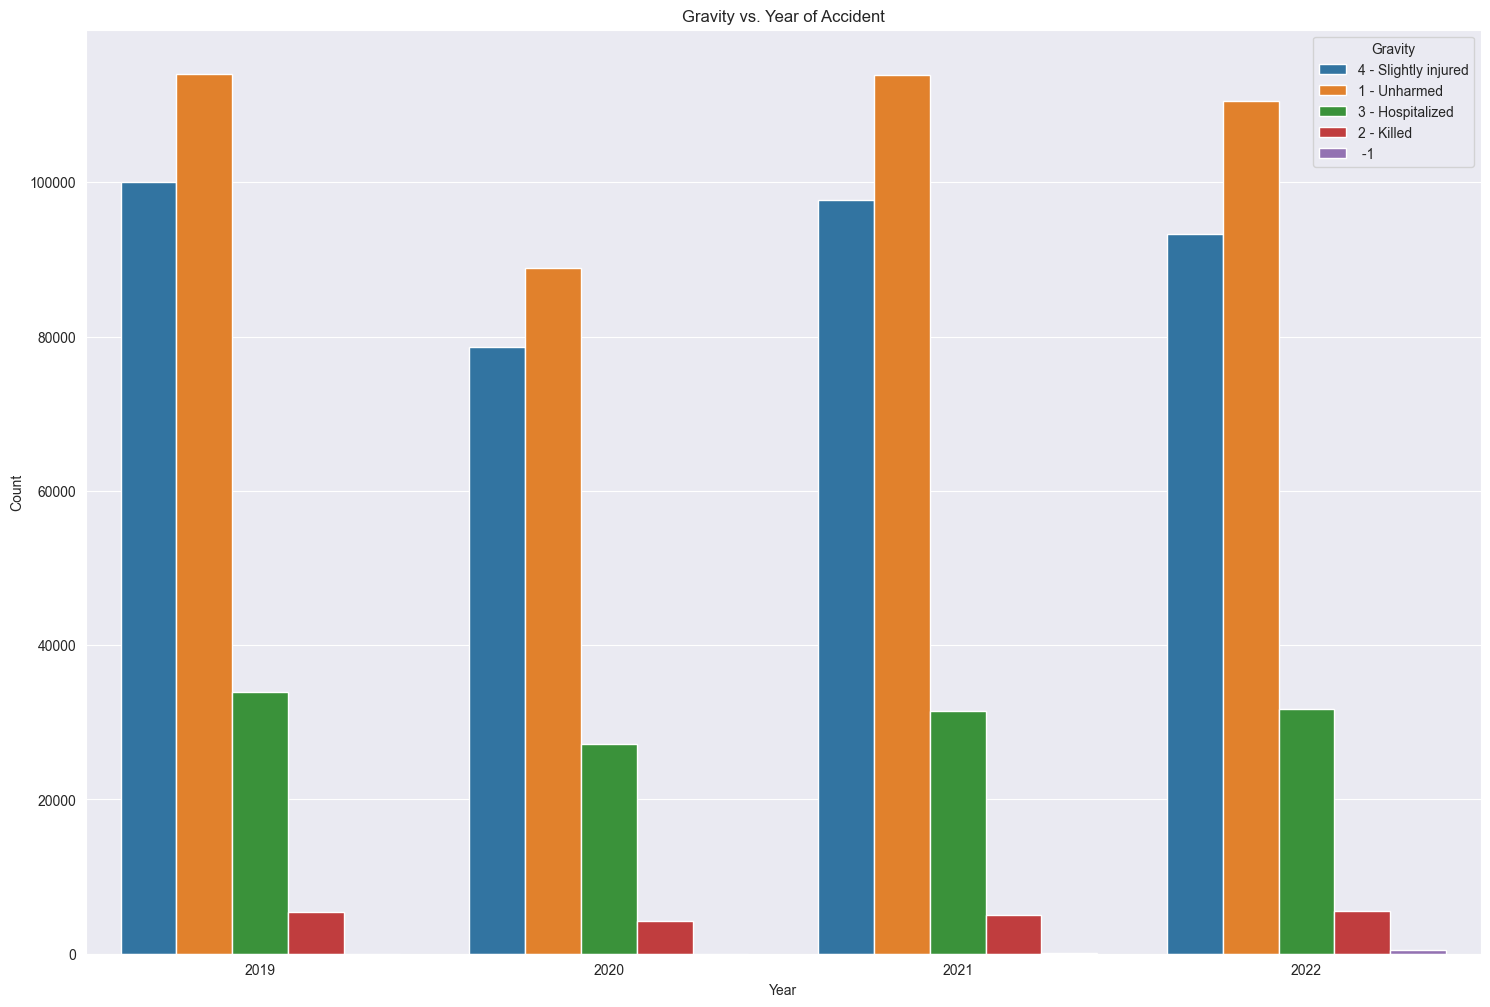

gravity,-1,1 - Unharmed,2 - Killed,3 - Hospitalized,4 - Slightly injured
year,,,,,
2019,0.0%,45.0%,2.1%,13.4%,39.5%
2020,0.0%,44.7%,2.1%,13.6%,39.6%
2021,0.0%,45.9%,2.0%,12.7%,39.4%
2022,0.2%,45.8%,2.3%,13.1%,38.6%


In [249]:
# Gravity vs. Year
plt.figure(figsize=(18, 12))
sns.countplot(data=data, x='year', hue='gravity')
plt.title('Gravity vs. Year of Accident')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title='Gravity')
plt.show()

# Gravity vs. Year
calculate_and_display_percentages(data, 'year')


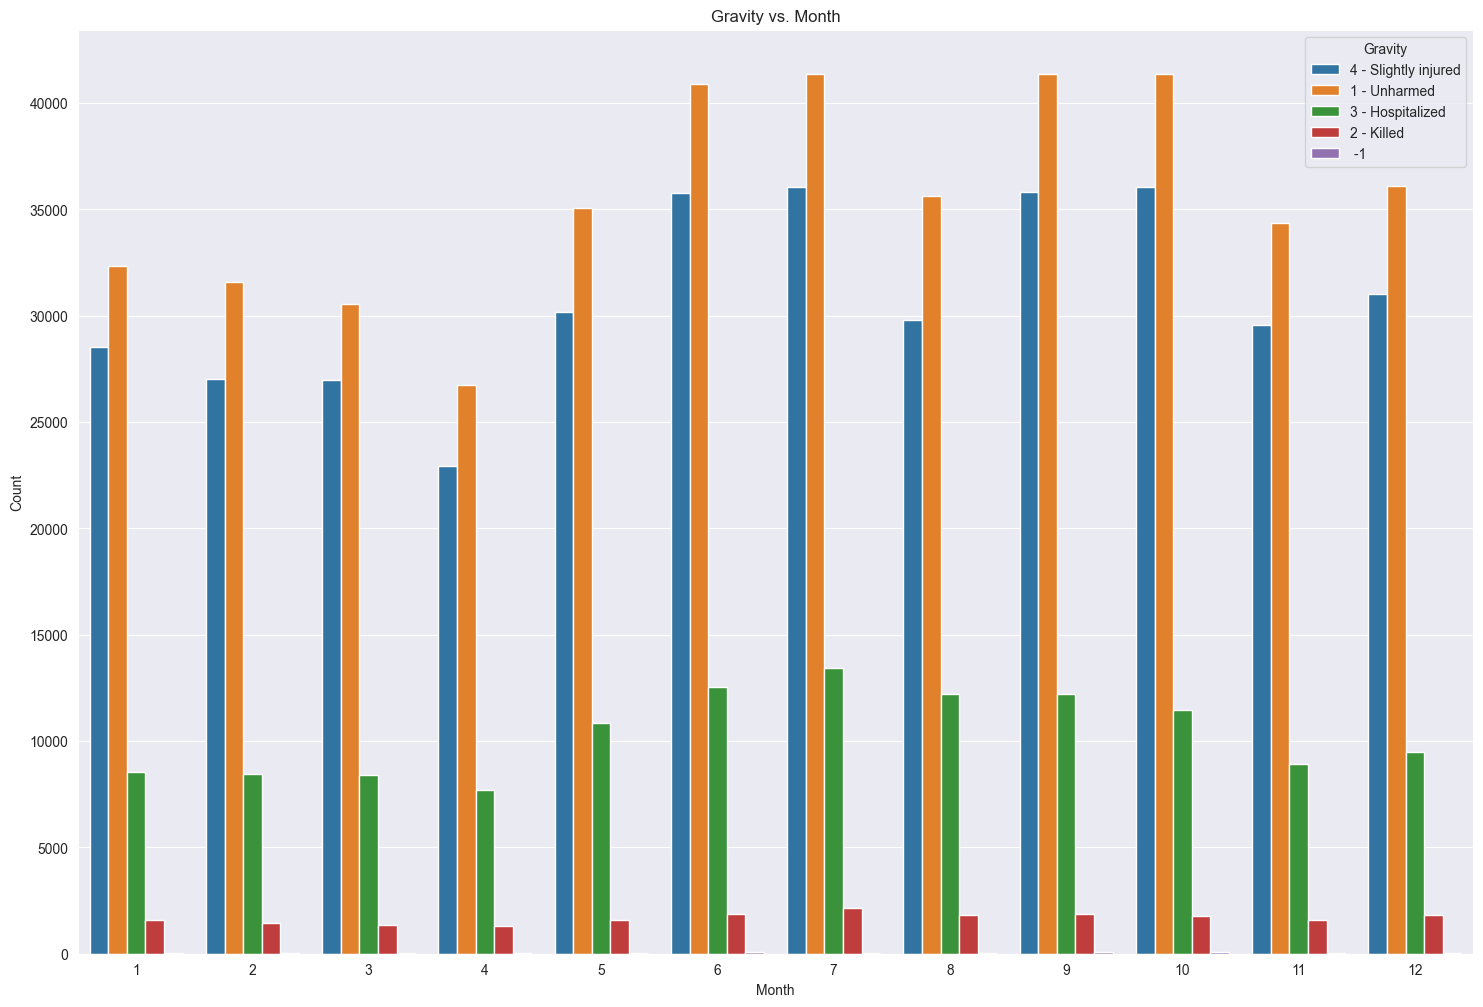

gravity,-1,1 - Unharmed,2 - Killed,3 - Hospitalized,4 - Slightly injured
month,,,,,
1,0.0%,45.5%,2.2%,12.0%,40.2%
2,0.1%,46.1%,2.1%,12.4%,39.4%
3,0.1%,45.4%,2.0%,12.4%,40.1%
4,0.0%,45.5%,2.2%,13.1%,39.1%
5,0.0%,45.1%,2.1%,14.0%,38.8%
6,0.1%,44.9%,2.0%,13.8%,39.2%
7,0.1%,44.4%,2.3%,14.4%,38.8%
8,0.0%,44.8%,2.3%,15.4%,37.5%
9,0.1%,45.3%,2.1%,13.4%,39.2%


In [250]:
# Gravity vs. Month
plt.figure(figsize=(18, 12))
sns.countplot(data=data, x='month', hue='gravity')
plt.title('Gravity vs. Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend(title='Gravity')
plt.show()

# Gravity vs. Month
calculate_and_display_percentages(data, 'month')

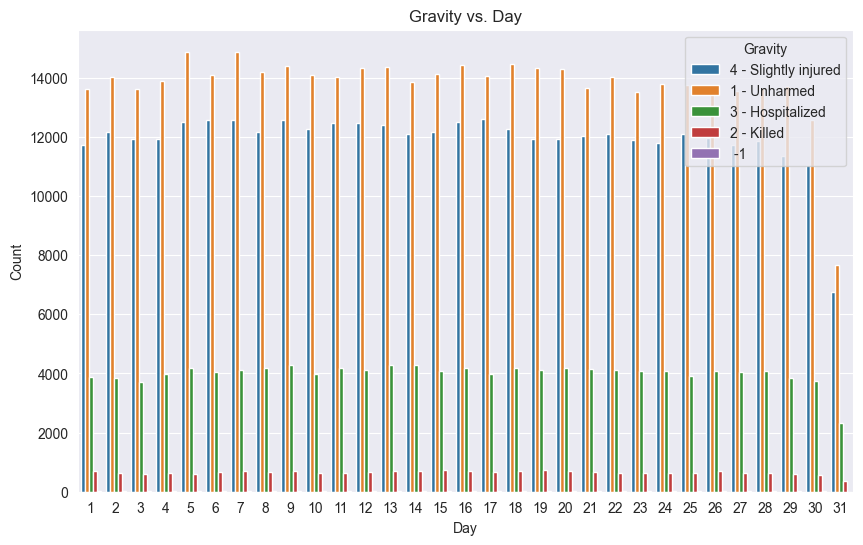

gravity,-1,1 - Unharmed,2 - Killed,3 - Hospitalized,4 - Slightly injured
day,,,,,
1,0.1%,45.5%,2.3%,13.0%,39.1%
2,0.1%,45.7%,2.1%,12.5%,39.7%
3,0.0%,45.5%,2.0%,12.4%,40.0%
4,0.1%,45.6%,2.1%,13.1%,39.1%
5,0.0%,46.2%,1.9%,13.0%,38.8%
6,0.1%,44.9%,2.1%,12.9%,40.1%
7,0.0%,46.1%,2.1%,12.7%,39.0%
8,0.1%,45.4%,2.1%,13.4%,38.9%
9,0.1%,45.0%,2.2%,13.4%,39.3%


In [251]:
# Gravity vs. Day
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='day', hue='gravity')
plt.title('Gravity vs. Day')
plt.xlabel('Day')
plt.ylabel('Count')
plt.legend(title='Gravity')
plt.show()

# Gravity vs. Day
calculate_and_display_percentages(data, 'day')

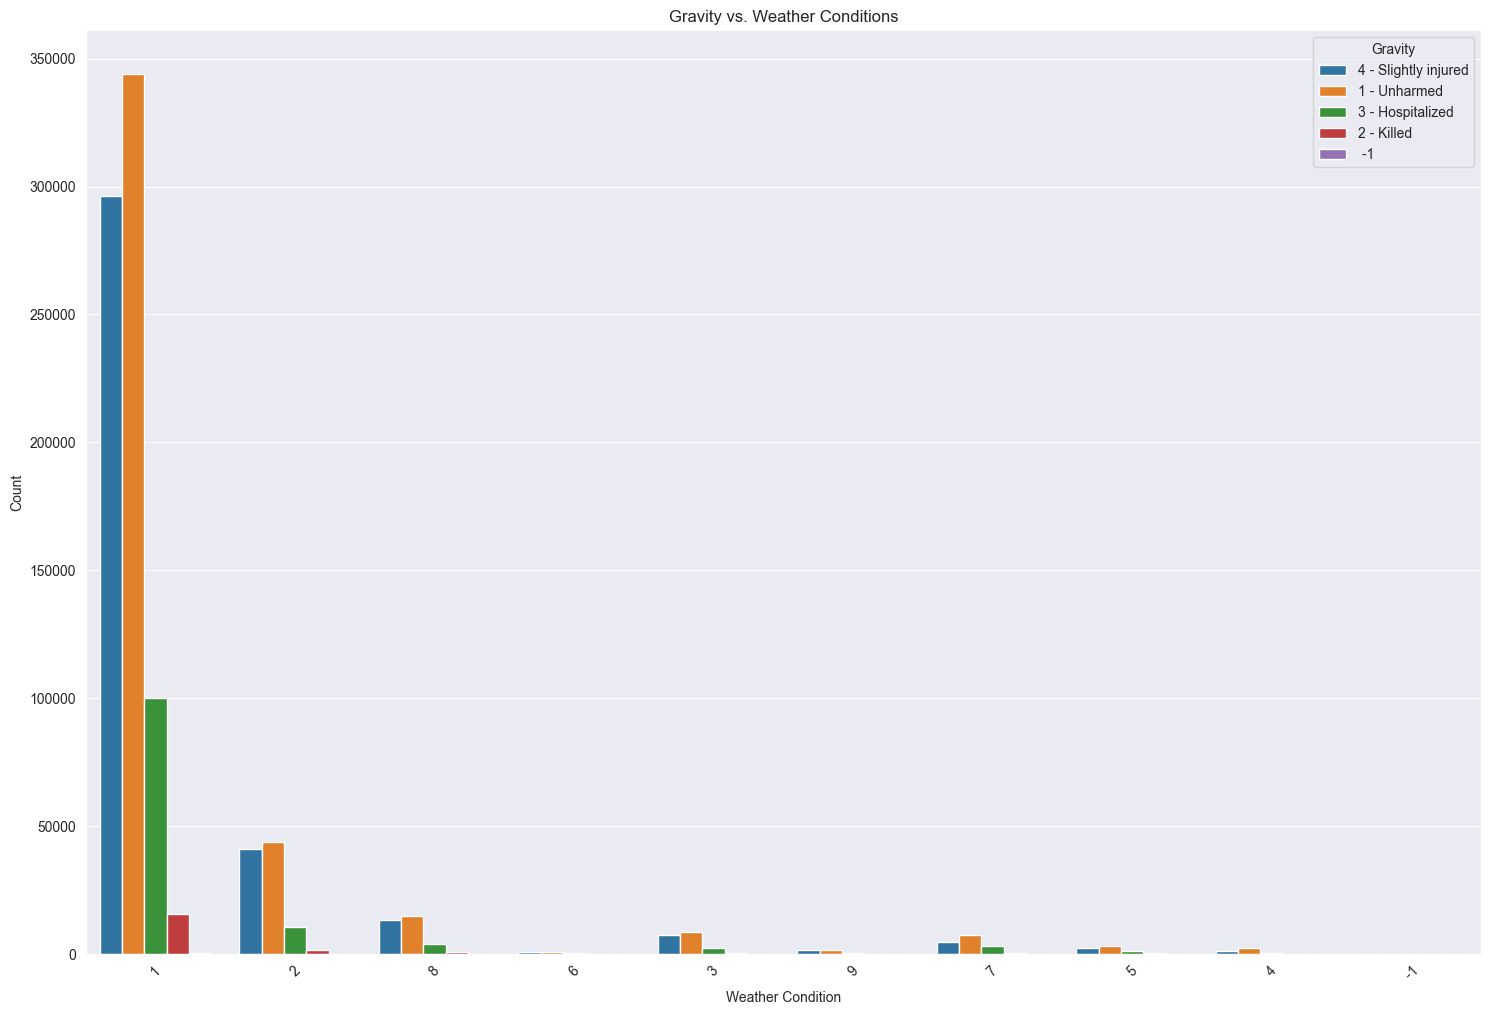

gravity,-1,1 - Unharmed,2 - Killed,3 - Hospitalized,4 - Slightly injured
atm_condition,,,,,
-1,2.4%,29.3%,9.8%,4.9%,53.7%
1,0.1%,45.5%,2.1%,13.2%,39.2%
2,0.1%,44.9%,1.9%,11.1%,42.1%
3,0.0%,45.1%,2.4%,13.4%,39.1%
4,0.1%,54.5%,2.4%,12.5%,30.5%
5,0.1%,44.9%,4.6%,17.9%,32.5%
6,0.0%,37.1%,4.2%,23.6%,35.1%
7,0.0%,46.3%,3.1%,20.4%,30.1%
8,0.0%,44.2%,2.8%,12.6%,40.4%


In [252]:
# Gravity vs. Weather Conditions (atm_condition)
plt.figure(figsize=(18, 12))
sns.countplot(data=data, x='atm_condition', hue='gravity')
plt.title('Gravity vs. Weather Conditions')
plt.xlabel('Weather Condition')
plt.ylabel('Count')
plt.legend(title='Gravity')
plt.xticks(rotation=45)
plt.show()

# Gravity vs. Weather Conditions (atm_condition)
calculate_and_display_percentages(data, 'atm_condition')

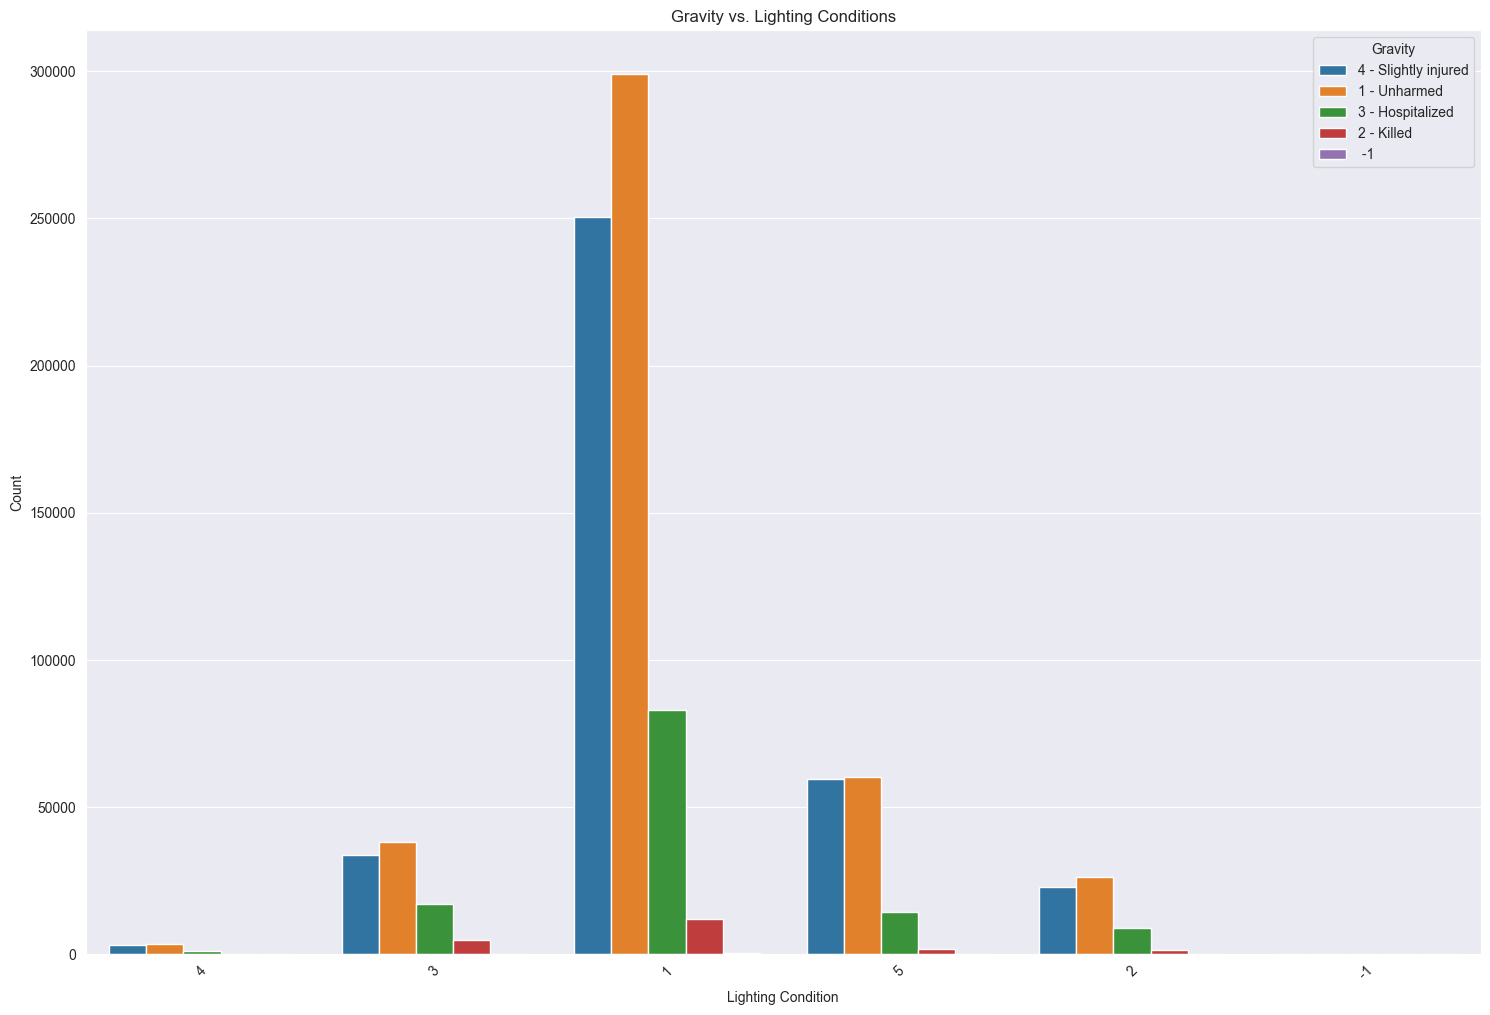

gravity,-1,1 - Unharmed,2 - Killed,3 - Hospitalized,4 - Slightly injured
lum,,,,,
-1,7.1%,28.6%,7.1%,0.0%,57.1%
1,0.1%,46.4%,1.8%,12.9%,38.9%
2,0.0%,44.3%,2.5%,14.9%,38.3%
3,0.0%,40.7%,5.1%,18.1%,36.1%
4,0.1%,44.0%,3.2%,12.6%,40.1%
5,0.1%,44.3%,1.3%,10.6%,43.6%


In [253]:
# Gravity vs. Lighting Conditions (lum)
plt.figure(figsize=(18, 12))
sns.countplot(data=data, x='lum', hue='gravity')
plt.title('Gravity vs. Lighting Conditions')
plt.xlabel('Lighting Condition')
plt.ylabel('Count')
plt.legend(title='Gravity')
plt.xticks(rotation=45)
plt.show()

# Gravity vs. Lighting Conditions (lum)
calculate_and_display_percentages(data, 'lum')

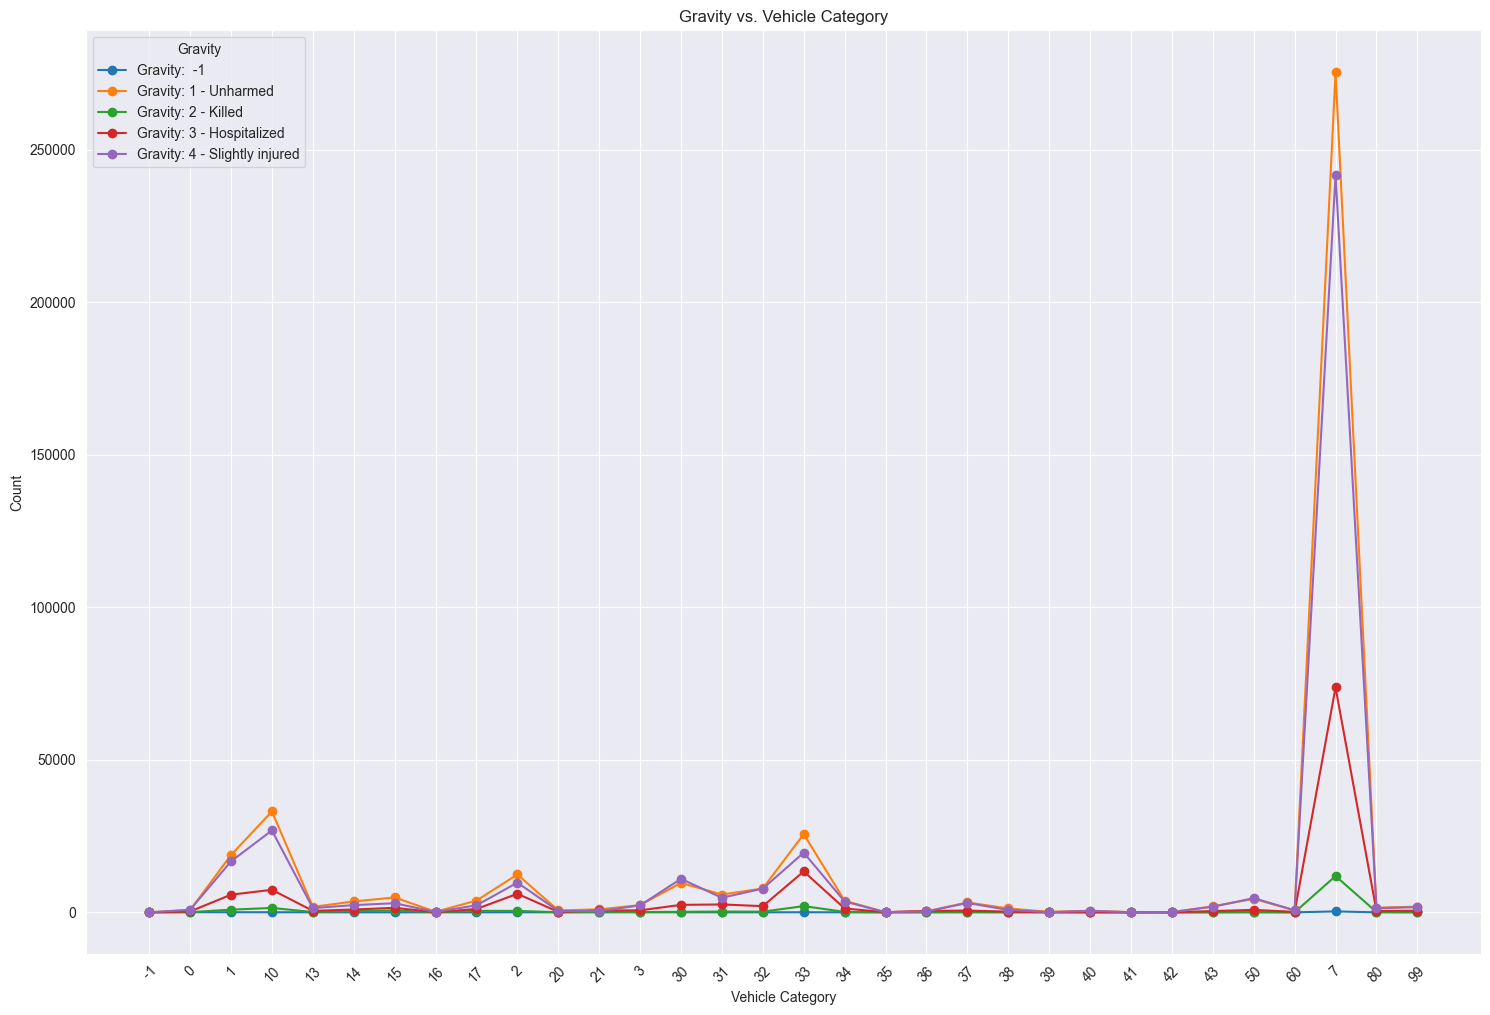

In [258]:
# Aggregate the data by vehicle_category and gravity
agg_data = data.groupby(['vehicle_category', 'gravity']).size().unstack(fill_value=0)

# Gravity vs. Vehicle Category - Line Plot
plt.figure(figsize=(18, 12))
for gravity in agg_data.columns:
    plt.plot(agg_data.index, agg_data[gravity], marker='o', label=f'Gravity: {gravity}')

plt.title('Gravity vs. Vehicle Category')
plt.xlabel('Vehicle Category')
plt.ylabel('Count')
plt.legend(title='Gravity')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


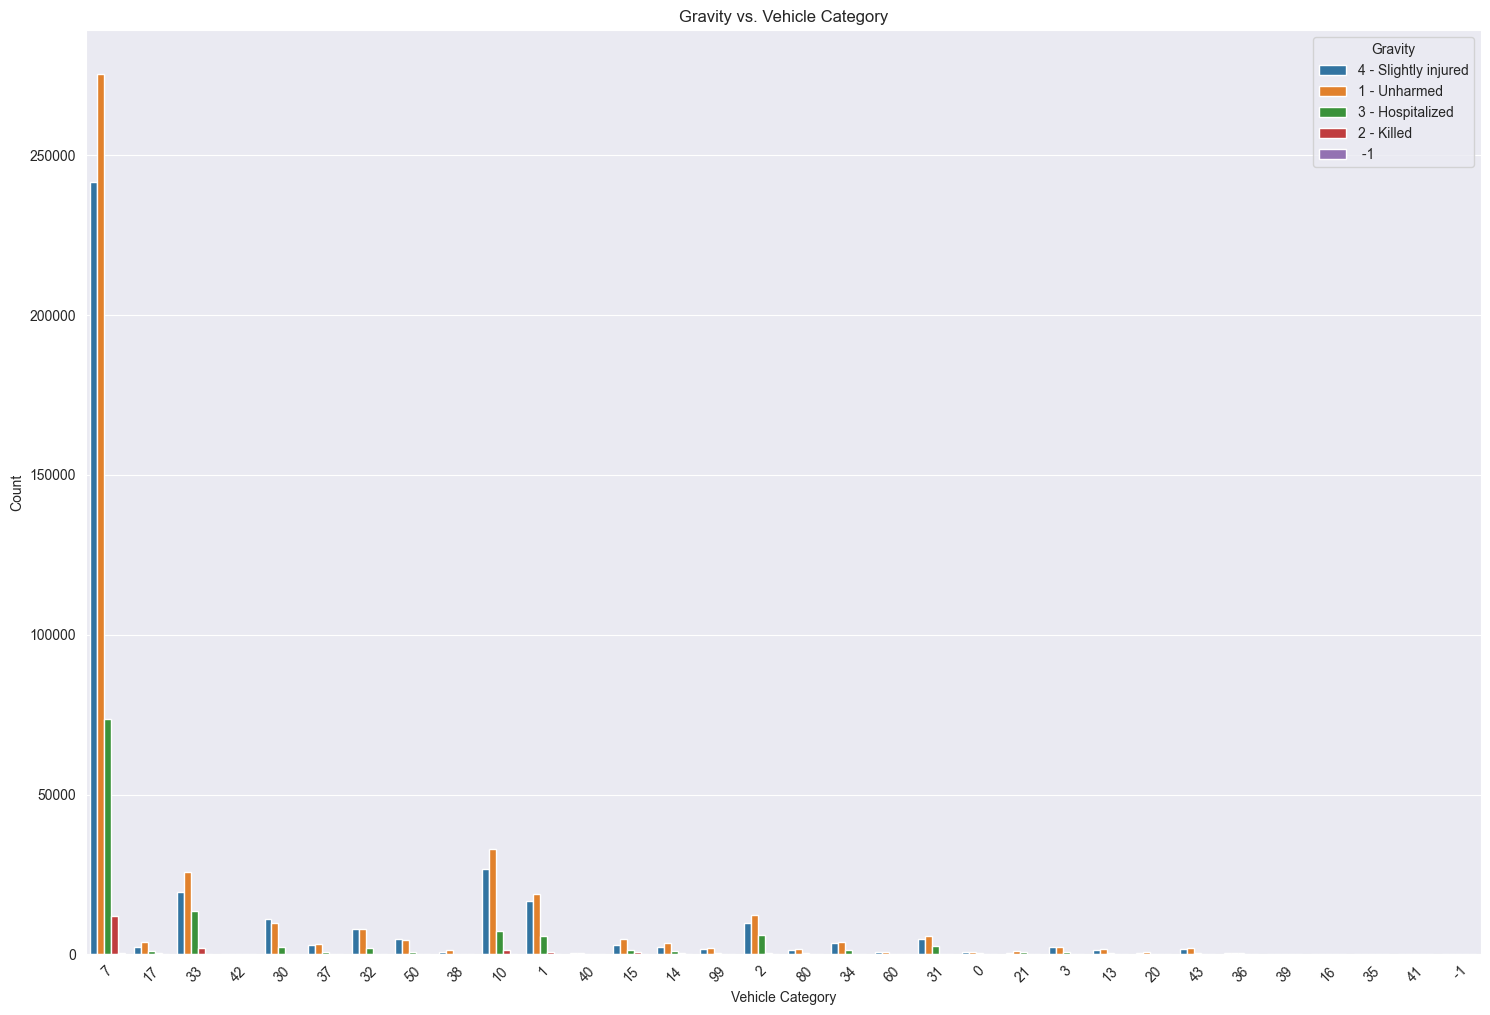

gravity,-1,1 - Unharmed,2 - Killed,3 - Hospitalized,4 - Slightly injured
vehicle_category,,,,,
-1,0.0%,44.0%,12.0%,16.0%,28.0%
0,2.7%,36.6%,2.7%,14.7%,43.3%
1,0.1%,44.5%,2.1%,13.7%,39.6%
10,0.0%,48.1%,2.1%,10.7%,39.0%
13,0.2%,47.3%,2.8%,13.0%,36.7%
14,0.0%,49.1%,5.6%,12.7%,32.6%
15,0.0%,49.0%,6.2%,14.8%,30.0%
16,0.3%,48.4%,3.6%,14.6%,33.2%
17,0.0%,49.7%,6.4%,14.2%,29.7%


In [254]:
# Gravity vs. Vehicle Category
plt.figure(figsize=(18, 12))
sns.countplot(data=data, x='vehicle_category', hue='gravity')
plt.title('Gravity vs. Vehicle Category')
plt.xlabel('Vehicle Category')
plt.ylabel('Count')
plt.legend(title='Gravity')
plt.xticks(rotation=45)
plt.show()

# Gravity vs. Vehicle Category
calculate_and_display_percentages(data, 'vehicle_category')

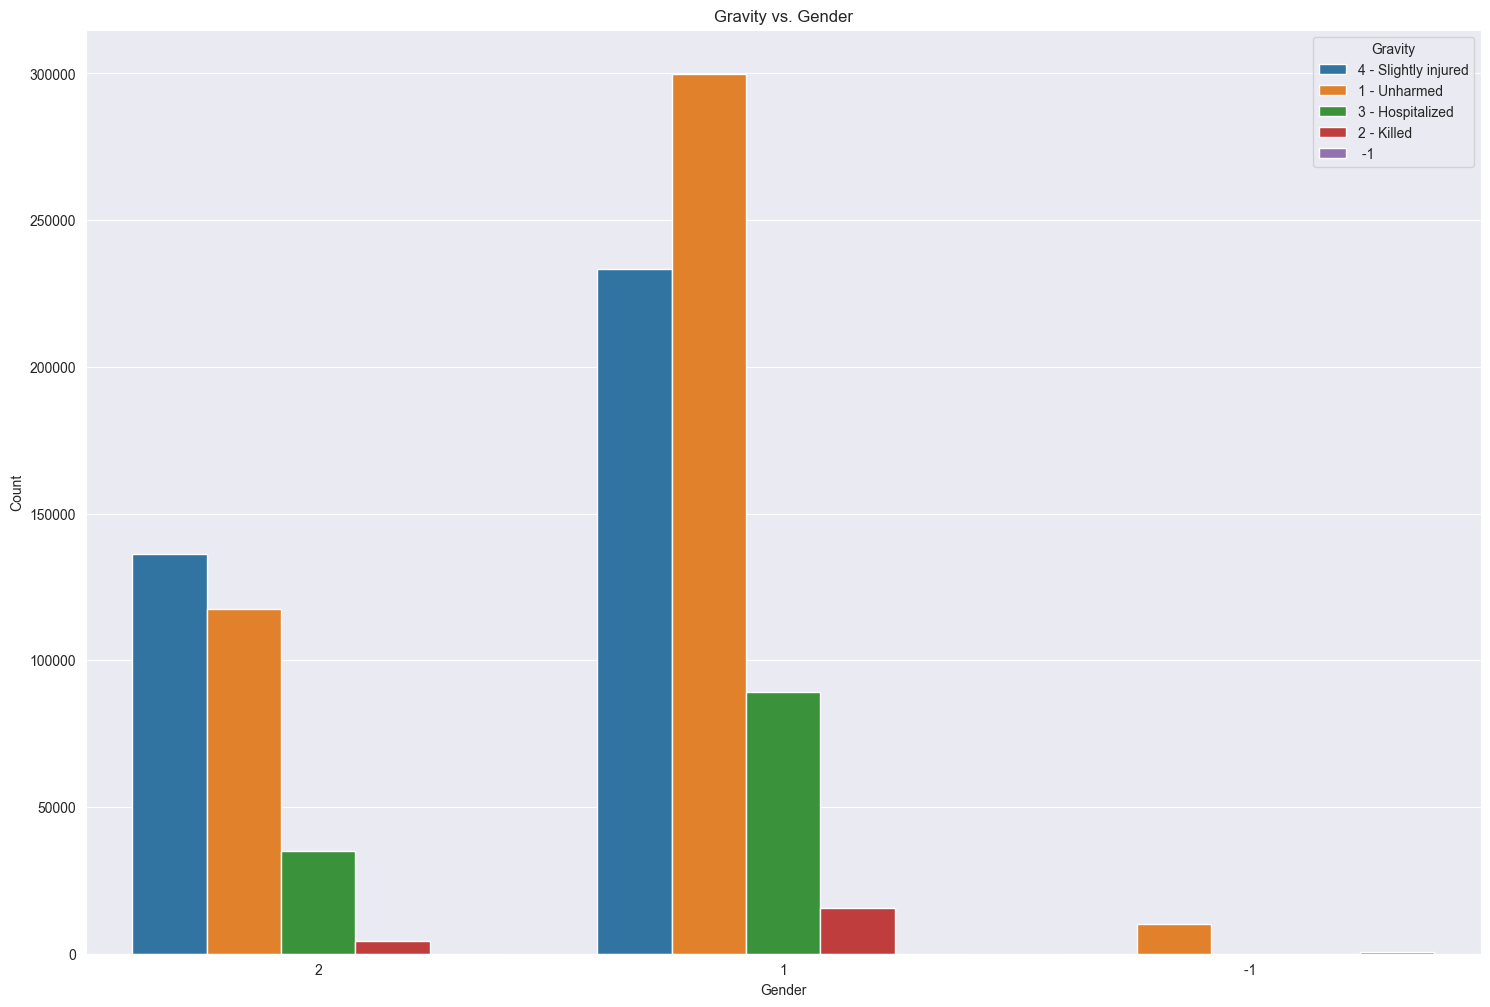

gravity,-1,1 - Unharmed,2 - Killed,3 - Hospitalized,4 - Slightly injured
gender,,,,,
-1,5.3%,94.7%,0.0%,0.0%,0.0%
1,0.0%,47.0%,2.5%,14.0%,36.6%
2,0.0%,40.0%,1.5%,12.0%,46.5%


In [255]:
# Gravity vs. Gender
plt.figure(figsize=(18, 12))
sns.countplot(data=data, x='gender', hue='gravity')
plt.title('Gravity vs. Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Gravity')
plt.show()

# Gravity vs. Gender
calculate_and_display_percentages(data, 'gender')

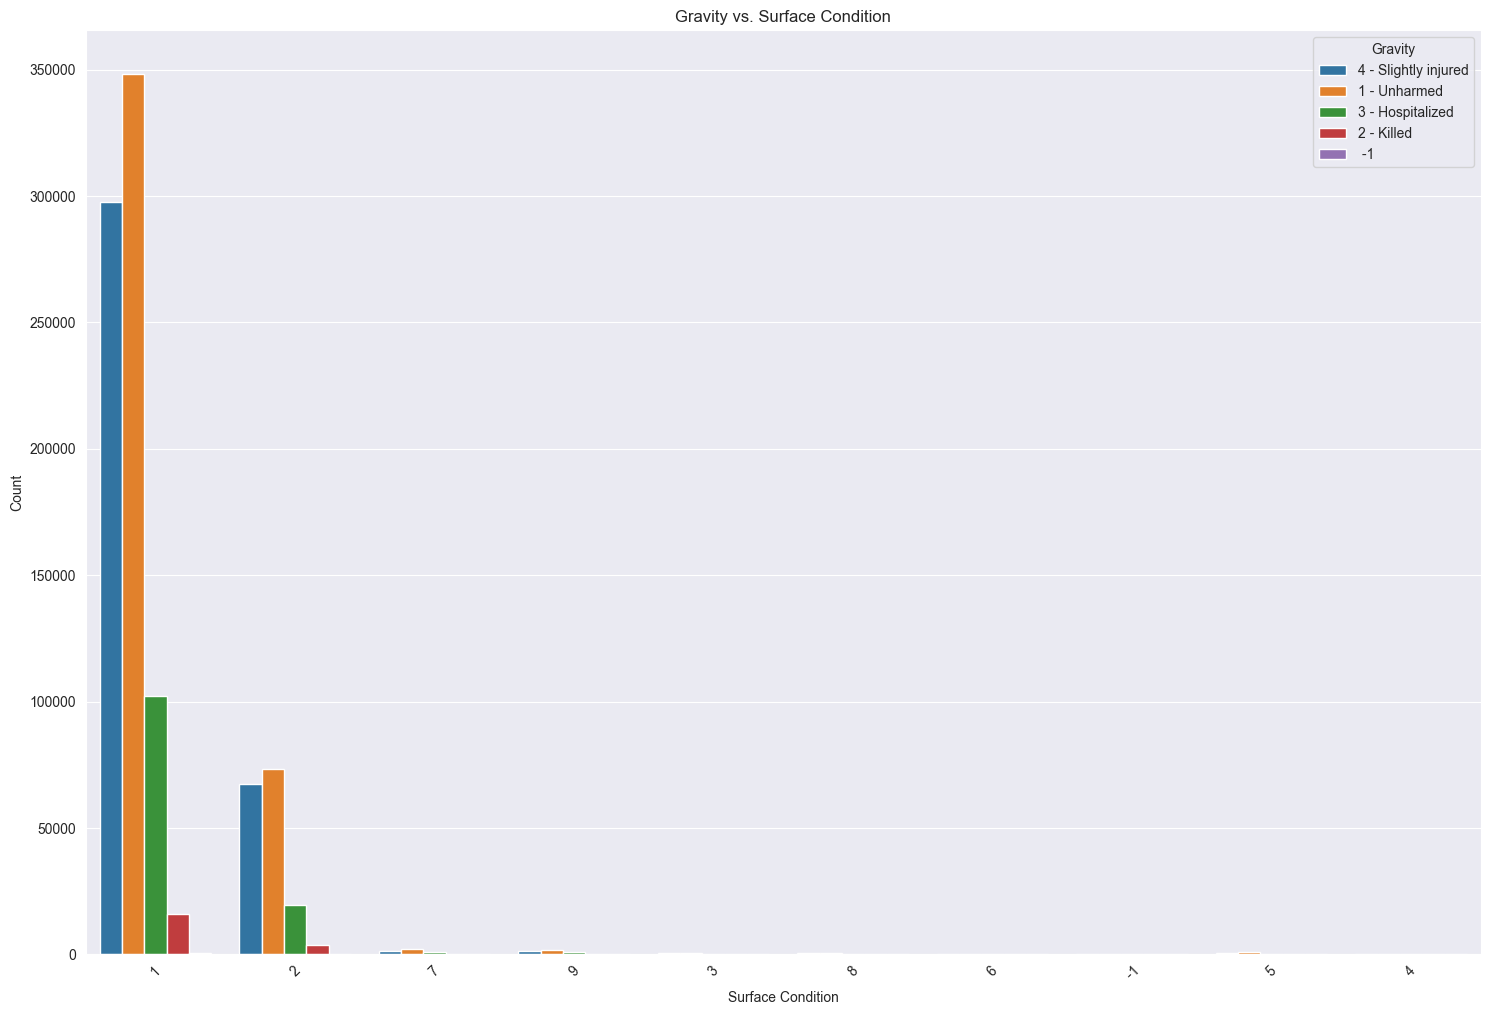

gravity,-1,1 - Unharmed,2 - Killed,3 - Hospitalized,4 - Slightly injured
surface_condition,,,,,
-1,0.6%,40.8%,5.2%,14.4%,39.1%
1,0.1%,45.5%,2.1%,13.4%,38.9%
2,0.0%,44.7%,2.3%,11.9%,41.2%
3,0.0%,43.1%,2.4%,16.9%,37.7%
4,0.0%,43.5%,3.0%,15.9%,37.6%
5,0.2%,50.8%,2.6%,12.9%,33.5%
6,0.0%,28.8%,6.8%,32.5%,31.9%
7,0.1%,48.8%,3.9%,16.7%,30.5%
8,0.0%,39.7%,1.3%,17.4%,41.6%


In [256]:
# Gravity vs. Surface Condition
plt.figure(figsize=(18,12))
sns.countplot(data=data, x='surface_condition', hue='gravity')
plt.title('Gravity vs. Surface Condition')
plt.xlabel('Surface Condition')
plt.ylabel('Count')
plt.legend(title='Gravity')
plt.xticks(rotation=45)
plt.show()

# Gravity vs. Surface Condition
calculate_and_display_percentages(data, 'surface_condition')

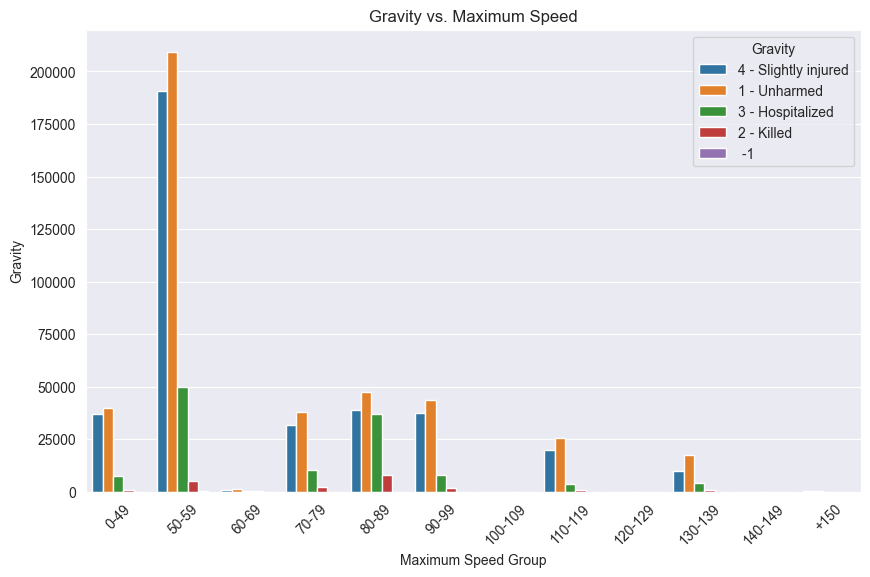

C:\Users\sd10725\AppData\Local\Temp\ipykernel_13512\2009690530.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = data.groupby([group_by_col, 'gravity']).size().reset_index(name='count')


gravity,-1,1 - Unharmed,2 - Killed,3 - Hospitalized,4 - Slightly injured
speed_group,,,,,
0-49,0.1%,46.7%,1.0%,8.7%,43.6%
50-59,0.1%,46.0%,1.1%,10.9%,41.9%
60-69,0.0%,41.5%,4.8%,17.1%,36.5%
70-79,0.0%,46.2%,2.5%,12.8%,38.4%
80-89,0.0%,36.0%,6.0%,28.3%,29.7%
90-99,0.0%,48.3%,1.9%,8.8%,41.0%
100-109,0.0%,37.3%,1.5%,18.7%,42.5%
110-119,0.0%,50.7%,2.0%,7.7%,39.6%
120-129,0.0%,50.0%,0.0%,0.0%,50.0%


In [257]:
# Define the bins and corresponding labels
bins = [0, 49, 59, 69, 79, 89, 99, 109, 119, 129, 139, 149, float('inf')]
labels = ['0-49', '50-59', '60-69', '70-79', '80-89', '90-99', '100-109', '110-119', '120-129', '130-139', '140-149', '+150']

# Create a new column for the binned speeds
data['speed_group'] = pd.cut(data['maximum_speed'], bins=bins, labels=labels, right=False)

# Gravity vs. Maximum Speed
plt.figure(figsize=(10, 6))
#sns.scatterplot(data=data, x='speed_group', y='gravity', hue='gravity', palette='viridis')
sns.countplot(data=data, x='speed_group', hue='gravity')

plt.title('Gravity vs. Maximum Speed')
plt.xlabel('Maximum Speed Group')
plt.ylabel('Gravity')
plt.legend(title='Gravity')
plt.xticks(rotation=45)
plt.show()

# Gravity vs. Maximum Speed
calculate_and_display_percentages(data, 'speed_group')